In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pprint import pprint
%matplotlib inline

In [36]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LeakyReLU
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam, RMSprop
from keras import metrics
from keras.wrappers.scikit_learn import KerasRegressor

In [3]:
start = datetime(2000,1,1)
end = datetime(2016,1,1)

In [4]:
original_data = pdr.get_data_yahoo('SPY', start, end)
original_data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

In [5]:
original_data.head()

,Open,High,Low,Close
Date,,,,
1999-12-31,146.843704,147.500000,146.250000,146.8750
2000-01-03,148.250000,148.250000,143.875000,145.4375
2000-01-04,143.531204,144.062500,139.640594,139.7500
2000-01-05,139.937500,141.531204,137.250000,140.0000
2000-01-06,139.625000,141.500000,137.750000,137.7500


### Create data representation

In [6]:
max_shift = 6

In [7]:
data = original_data.copy()
data.columns = pd.MultiIndex.from_product([['Shift 0'],['Open','High','Low','Close']])
for i in range(1, max_shift + 1):
    shifted = data.iloc[:,[0,1,2,3]].shift(i)
    shifted.columns = pd.MultiIndex.from_product([['Shift ' + str(i)],['Open','High','Low','Close']])
    data = pd.concat([data, shifted], axis=1)

In [8]:
data.head(6)

Shift 0                                       Shift 1  \
                  Open        High         Low     Close        Open   
Date                                                                   
1999-12-31  146.843704  147.500000  146.250000  146.8750         NaN   
2000-01-03  148.250000  148.250000  143.875000  145.4375  146.843704   
2000-01-04  143.531204  144.062500  139.640594  139.7500  148.250000   
2000-01-05  139.937500  141.531204  137.250000  140.0000  143.531204   
2000-01-06  139.625000  141.500000  137.750000  137.7500  139.937500   
2000-01-07  140.312500  145.750000  140.062500  145.7500  139.625000   

                                                 Shift 2              ...   \
                  High         Low     Close        Open        High  ...    
Date                                                                  ...    
1999-12-31         NaN         NaN       NaN         NaN         NaN  ...    
2000-01-03  147.500000  146.250000  146.8750         NaN         NaN  ...    
2000-01-04  148.250000  143.875000  145.4375  146.843704  147.500000  ...    
2000-01-05  144.062500  139.640594  139.7500  148.250000  148.250000  ...    
2000-01-06  141.531204  137.250000  140.0000  143.531204  144.062500  ...    
2000-01-07  141.500000  137.750000  137.7500  139.937500  141.531204  ...    

            Shift 4               Shift 5                         Shift 6  \
                Low     Close        Open   High     Low    Close    Open   
Date                                                                        
1999-12-31      NaN       NaN         NaN    NaN     NaN      NaN     NaN   
2000-01-03      NaN       NaN         NaN    NaN     NaN      NaN     NaN   
2000-01-04      NaN       NaN         NaN    NaN     NaN      NaN     NaN   
2000-01-05      NaN       NaN         NaN    NaN     NaN      NaN     NaN   
2000-01-06  146.250  146.8750         NaN    NaN     NaN      NaN     NaN   
2000-01-07  143.875  145.4375  146.843704  147.5  146.25  146.875     NaN   

                           
           High Low Close  
Date                       
1999-12-31  NaN NaN   NaN  
2000-01-03  NaN NaN   NaN  
2000-01-04  NaN NaN   NaN  
2000-01-05  NaN NaN   NaN  
2000-01-06  NaN NaN   NaN  
2000-01-07  NaN NaN   NaN  

[6 rows x 28 columns]

In [9]:
data['Shift 2', 'Close'].head(3)

Date
1999-12-31        NaN
2000-01-03        NaN
2000-01-04    146.875
Name: (Shift 2, Close), dtype: float64

In [10]:
for i in range(0, max_shift):
    data['Shift ' + str(i), 'Bull ' + str(i)] = data['Shift ' + str(i), 'Close'] > data['Shift ' + str(i), 'Open']

In [11]:
data['Shift 0'].head(2)

,Open,High,Low,Close,Bull 0
Date,,,,,
1999-12-31,146.843704,147.50,146.250,146.8750,True
2000-01-03,148.250000,148.25,143.875,145.4375,False


In [12]:
for i in range(0, max_shift):
    data['Shift ' + str(i), 'GT ' + str(i)] = data['Shift ' + str(i), 'Open'] > data['Shift ' + str(i+1), 'Close']

In [13]:
data[['Shift 0', 'Shift 1']].head()

Shift 0                                                  \
                  Open        High         Low     Close Bull 0   GT 0   
Date                                                                     
1999-12-31  146.843704  147.500000  146.250000  146.8750   True  False   
2000-01-03  148.250000  148.250000  143.875000  145.4375  False   True   
2000-01-04  143.531204  144.062500  139.640594  139.7500  False  False   
2000-01-05  139.937500  141.531204  137.250000  140.0000   True   True   
2000-01-06  139.625000  141.500000  137.750000  137.7500  False  False   

               Shift 1                                                  
                  Open        High         Low     Close Bull 1   GT 1  
Date                                                                    
1999-12-31         NaN         NaN         NaN       NaN  False  False  
2000-01-03  146.843704  147.500000  146.250000  146.8750   True  False  
2000-01-04  148.250000  148.250000  143.875000  145.4375  False   True  
2000-01-05  143.531204  144.062500  139.640594  139.7500  False  False  
2000-01-06  139.937500  141.531204  137.250000  140.0000   True   True

In [14]:
shifted = data.iloc[:,[0,1,2,3]].shift(-5)
shifted.columns = pd.MultiIndex.from_product([['Shift -5'],['Open','High','Low','Close']])
data = pd.concat([data, shifted], axis=1)

In [15]:
data['Shift 0', 'Return'] = data['Shift -5', 'Close'] - data['Shift 0', 'Close']
data.head()

Shift 0                                       Shift 1  \
                  Open        High         Low     Close        Open   
Date                                                                   
1999-12-31  146.843704  147.500000  146.250000  146.8750         NaN   
2000-01-03  148.250000  148.250000  143.875000  145.4375  146.843704   
2000-01-04  143.531204  144.062500  139.640594  139.7500  148.250000   
2000-01-05  139.937500  141.531204  137.250000  140.0000  143.531204   
2000-01-06  139.625000  141.500000  137.750000  137.7500  139.937500   

                                                 Shift 2             ...    \
                  High         Low     Close        Open      High   ...     
Date                                                                 ...     
1999-12-31         NaN         NaN       NaN         NaN       NaN   ...     
2000-01-03  147.500000  146.250000  146.8750         NaN       NaN   ...     
2000-01-04  148.250000  143.875000  145.4375  146.843704  147.5000   ...     
2000-01-05  144.062500  139.640594  139.7500  148.250000  148.2500   ...     
2000-01-06  141.531204  137.250000  140.0000  143.531204  144.0625   ...     

           Shift 1 Shift 2 Shift 3 Shift 4 Shift 5    Shift -5              \
              GT 1    GT 2    GT 3    GT 4    GT 5        Open        High   
Date                                                                         
1999-12-31   False   False   False   False   False  140.312500  145.750000   
2000-01-03   False   False   False   False   False  146.250000  146.906204   
2000-01-04    True   False   False   False   False  145.812500  146.093704   
2000-01-05   False    True   False   False   False  144.593704  144.593704   
2000-01-06    True   False    True   False   False  144.468704  145.750000   

                                 Shift 0  
                   Low     Close  Return  
Date                                      
1999-12-31  140.062500  145.7500 -1.1250  
2000-01-03  145.031204  146.2500  0.8125  
2000-01-04  143.500000  144.5000  4.7500  
2000-01-05  142.875000  143.0625  3.0625  
2000-01-06  143.281204  145.0000  7.2500  

[5 rows x 45 columns]

In [16]:
binary_data = data.drop(['Open', 'High', 'Low', 'Close'], axis=1, level=1)
binary_data.head()

,Shift 0,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 0,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 0
,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,GT 0,GT 1,GT 2,GT 3,GT 4,GT 5,Return
Date,,,,,,,,,,,,,
1999-12-31,True,False,False,False,False,False,False,False,False,False,False,False,-1.1250
2000-01-03,False,True,False,False,False,False,True,False,False,False,False,False,0.8125
2000-01-04,False,False,True,False,False,False,False,True,False,False,False,False,4.7500
2000-01-05,True,False,False,True,False,False,True,False,True,False,False,False,3.0625
2000-01-06,False,True,False,False,True,False,False,True,False,True,False,False,7.2500


In [17]:
binary_data.columns = binary_data.columns.droplevel()

In [18]:
binary_data.head(10)

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,GT 0,GT 1,GT 2,GT 3,GT 4,GT 5,Return
Date,,,,,,,,,,,,,
1999-12-31,True,False,False,False,False,False,False,False,False,False,False,False,-1.125000
2000-01-03,False,True,False,False,False,False,True,False,False,False,False,False,0.812500
2000-01-04,False,False,True,False,False,False,False,True,False,False,False,False,4.750000
2000-01-05,True,False,False,True,False,False,True,False,True,False,False,False,3.062500
2000-01-06,False,True,False,False,True,False,False,True,False,True,False,False,7.250000
2000-01-07,True,False,True,False,False,True,True,False,True,False,True,False,1.218704
2000-01-10,False,True,False,True,False,False,True,True,False,True,False,True,-0.437500
2000-01-11,False,False,True,False,True,False,False,True,True,False,True,False,2.500000
2000-01-12,False,False,False,True,False,True,True,False,True,True,False,True,1.687500


### Explore data

In [19]:
binary_data.groupby(['Bull 0', 'GT 0', 'Bull 1', 'GT 1']).mean().sort_values('Return')

Bull 2    Bull 3    Bull 4    Bull 5      GT 2  \
Bull 0 GT 0  Bull 1 GT 1                                                      
True   True  True   False  0.518248  0.529197  0.540146  0.554745  0.576642   
       False True   True   0.456716  0.498507  0.576119  0.504478  0.534328   
False  False True   False  0.595652  0.508696  0.521739  0.556522  0.639130   
True   False False  False  0.517241  0.586207  0.563218  0.534483  0.586207   
                    True   0.544444  0.544444  0.503704  0.522222  0.514815   
       True  False  False  0.523333  0.536667  0.536667  0.490000  0.510000   
             True   True   0.444444  0.468254  0.500000  0.492063  0.500000   
       False True   False  0.594470  0.608295  0.608295  0.589862  0.608295   
False  False True   True   0.481343  0.477612  0.481343  0.529851  0.432836   
True   True  False  True   0.492958  0.510563  0.517606  0.492958  0.485915   
False  True  True   False  0.523636  0.454545  0.538182  0.549091  0.610909   
                    True   0.517647  0.541176  0.474510  0.576471  0.450980   
             False  True   0.536885  0.508197  0.500000  0.471311  0.463115   
                    False  0.536290  0.540323  0.483871  0.516129  0.564516   
       False False  True   0.500000  0.553571  0.517857  0.513393  0.486607   
                    False  0.670455  0.556818  0.494318  0.477273  0.551136   

                               GT 3      GT 4      GT 5    Return  
Bull 0 GT 0  Bull 1 GT 1                                           
True   True  True   False  0.572993  0.558394  0.540146 -0.269061  
       False True   True   0.546269  0.549254  0.489552 -0.202653  
False  False True   False  0.552174  0.526087  0.634783 -0.045070  
True   False False  False  0.568966  0.557471  0.459770  0.006623  
                    True   0.518519  0.514815  0.555556  0.019463  
       True  False  False  0.490000  0.543333  0.533333  0.048244  
             True   True   0.500000  0.523810  0.567460  0.063812  
       False True   False  0.585253  0.585253  0.483871  0.064916  
False  False True   True   0.507463  0.507463  0.563433  0.081582  
True   True  False  True   0.556338  0.464789  0.517606  0.083135  
False  True  True   False  0.512727  0.538182  0.538182  0.087837  
                    True   0.509804  0.533333  0.478431  0.168105  
             False  True   0.479508  0.520492  0.553279  0.182867  
                    False  0.487903  0.552419  0.483871  0.259105  
       False False  True   0.540179  0.495536  0.517857  0.286408  
                    False  0.573864  0.500000  0.545455  0.763307

# Train Keras NN

### Setup X_train, X_test, etc

In [20]:
binary_data.dropna(inplace=True)

In [21]:
X = binary_data.drop('Return', axis=1) - 0.5

In [22]:
y = binary_data['Return'] > 0

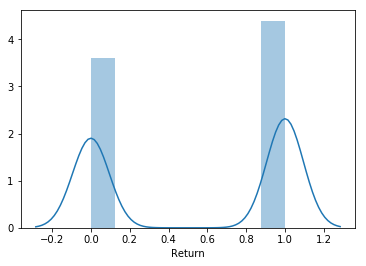

In [23]:
sns.distplot(y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Build model

In [44]:
model = Sequential()
model.add(Dense(20, input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(optimizer=Adam(),
              loss=binary_crossentropy,
              metrics=['accuracy'])

In [ ]:
model.fit(X_train.values, y_train.values, 
          validation_data=(X_test.values, y_test.values),
          epochs=50, 
          batch_size=64, 
          verbose=1)

Train on 3216 samples, validate on 805 samples
Epoch 1/50
3216/3216 [==============================] - 1s - loss: 0.6919 - acc: 0.5267 - val_loss: 0.6832 - val_acc: 0.5739
Epoch 2/50
3216/3216 [==============================] - 0s - loss: 0.6900 - acc: 0.5261 - val_loss: 0.6833 - val_acc: 0.5851
Epoch 3/50
3216/3216 [==============================] - 0s - loss: 0.6890 - acc: 0.5305 - val_loss: 0.6838 - val_acc: 0.5851
Epoch 4/50
3216/3216 [==============================] - 0s - loss: 0.6883 - acc: 0.5317 - val_loss: 0.6841 - val_acc: 0.5876
Epoch 5/50
3216/3216 [==============================] - 0s - loss: 0.6874 - acc: 0.5323 - val_loss: 0.6845 - val_acc: 0.5938
Epoch 6/50
3216/3216 [==============================] - 0s - loss: 0.6867 - acc: 0.5354 - val_loss: 0.6851 - val_acc: 0.5925
Epoch 7/50
3216/3216 [==============================] - 0s - loss: 0.6862 - acc: 0.5364 - val_loss: 0.6858 - val_acc: 0.5925
Epoch 8/50
3216/3216 [==============================] - 0s - loss: 0.6853 - ac

In [42]:
predicted = model.predict(X_test.values)

In [43]:
model.evaluate(X_test.values, y_test.values, verbose=3)

[0.70036310971893878, 0.53664596276994081]